# Notebook to create dictionary of concepts 
Create a visual dictionary of various concepts from MNIST Data set using the latent representation learned by a VAE


# Setup required for colab

In [1]:
%tensorflow_version 1.14.0
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/sunil/concepts_loss_origin/concept_learning/
!pwd
env="colab"

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Mounted at /content/gdrive
/content/gdrive/MyDrive/sunil/concepts_loss_origin/concept_learning
/content/gdrive/MyDrive/sunil/concepts_loss_origin/concept_learning


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [3]:
#!git pull

In [ ]:
if env == "sunil_local":
    root_path = "/Users/sunilv/concept_learning_exp"
elif env == "colab":
    root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"


In [ ]:
#import os
from typing import List, DefaultDict, Dict
from collections import defaultdict
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture

from matplotlib import pyplot as plt
from clearn.experiments.experiment import Experiment, load_trained_model, get_model, get_train_val_iterator, MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.dao.dao_factory import get_dao

import tensorflow as tf
from clearn.utils.data_loader import TrainValDataIterator, DataIterator
from clearn.utils.data_loader import load_images
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.semi_supervised_mnist import SemiSupervisedClassifierMnist
from clearn.config import ExperimentConfig
from matplotlib import pyplot  as  plt
from scipy.special import softmax
from clearn.analysis.encode_decode import decode
from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.analysis import ClusterGroup, Cluster, ManualAnnotation
from clearn.config import ExperimentConfig

%matplotlib inline



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import math
from math import log
import json
from numpy.linalg import norm
import logging

import matplotlib
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_train_val_iterator,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, get_cluster, display_images, segment, segment_multiple_images, cluster_next_level_gmm
from clearn.analysis.cluster_utils import get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance, cluster_and_decode_latent_vectors_gmm
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution, compute_distance_level_2
from clearn.analysis.cluster_utils import process_second_level_clusters, convert_distance_to_confidence, get_distance, get_cluster_groups, cluster_next_level_gmm
from PIL import Image

%matplotlib inline


In [ ]:
num_units = [512, 256, 256, 128, 64]
stride_5_layer = [2, 1, 2, 1, 2,  1]
create_split = True
experiment_name = "exp_concepts_1"
num_epochs = 50
run_id = 1
z_dim = 16
train_val_data_iterator = None



In [ ]:
layer_num=len(num_units) - 2
label_list = list(range(10,28))
print(label_list)
print(layer_num)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
3


In [ ]:
exp_config = ExperimentConfig(root_path=root_path,
                              num_decoder_layer=4,
                              num_cluster_config=None,
                              supervise_weight=0,
                              name=experiment_name,
                              z_dim=z_dim,
                              batch_size=512,
                              beta=5,
                              reconstruction_weight=1,
                              num_units=num_units,
                              save_reconstructed_images=True,
                              split_name="split_70_30",
                              dataset_name="mnist_concepts",
                              eval_interval_in_epochs=4,
                              model_save_interval=10,
                              num_val_samples=-1,
                              run_evaluation_during_training=True,
                              return_latent_vector=False,
                              write_predictions=True,
                              fully_convolutional = True,
                              num_concepts=28,
                              strides=stride_5_layer,
                              activation_output_layer = "SIGMOID",
                              num_dense_layers=0,
                              uncorrelated_features=False,
                              concept_dict = { 6: {"unique_concepts":[-1]},
                                              layer_num:{"unique_concepts":label_list
                                                },
                                              },
                              concept_id=20
                              )
exp_config.check_and_create_directories(run_id)


/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets/ split_70_30 manually_generated_concepts.json
Reading concepts map from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/datasets//mnist_concepts/split_70_30/manually_generated_concepts.json
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


True

In [ ]:
_exp_config = exp_config

In [ ]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= _exp_config.dao,
                                                 exp_config= _exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=_exp_config.split_name)

train_images, train_labels, _ = load_images(_exp_config,
                                          train_val_data_iterator,
                                          "train"
                                          )
train_labels= np.argwhere(train_labels == 1)[:,1]

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
<class 'numpy.ndarray'> int64
Loaded manual annotation
Number of samples with manual confidence 73414
Warning /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_1/analysis/manual_annotation.csv path does not exist. Creating random prior with uniform distribution


In [ ]:
height, width = train_images.shape[1], train_images.shape[2]
num_training_images = train_images.shape[0]

In [ ]:
num_segments=4
labels_dict=dict()
cluster_dict = dict()
cluster_dict_level_2 = dict()

In [ ]:
num_second_level_cluster = 10


In [ ]:
exp_config.num_val_samples

-1

# Cluster latent vectors in training set

In [ ]:
from clearn.analysis.cluster_utils import  cluster_and_decode_latent_vectors_gmm


In [ ]:
_exp_config.dao.num_validation_samples

31464

In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = _exp_config.dao,
              exp_config=_exp_config,
              model_type=model_type,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = _exp_config.num_train_samples / _exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Encoding
Decoding
layer_num 3 de_conv_3
(512, 14, 14, 256)
(512, 14, 14, 256)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 10
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 11
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 12
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 13
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 14
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 15
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 16
input shape  (512

In [ ]:
epochs_completed = 46.0

In [ ]:
!ls /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/exp_concepts_1/Exp_64_128_256_256_512_16_1/analysis


manual_annotation.csv		z_train_128_64_16_epoch_31.csv
metrics_0.csv			z_train_128_64_16_epoch_36.csv
z_test_128_64_16_epoch_11.csv	z_train_128_64_16_epoch_41.csv
z_test_128_64_16_epoch_16.csv	z_train_128_64_16_epoch_46.csv
z_test_128_64_16_epoch_1.csv	z_train_128_64_16_epoch_50.csv
z_test_128_64_16_epoch_21.csv	z_train_128_64_16_epoch_6.csv
z_test_128_64_16_epoch_26.csv	z_val_128_64_16_epoch_11.csv
z_test_128_64_16_epoch_31.csv	z_val_128_64_16_epoch_16.csv
z_test_128_64_16_epoch_36.csv	z_val_128_64_16_epoch_1.csv
z_test_128_64_16_epoch_41.csv	z_val_128_64_16_epoch_21.csv
z_test_128_64_16_epoch_46.csv	z_val_128_64_16_epoch_26.csv
z_test_128_64_16_epoch_50.csv	z_val_128_64_16_epoch_31.csv
z_test_128_64_16_epoch_6.csv	z_val_128_64_16_epoch_36.csv
z_train_128_64_16_epoch_11.csv	z_val_128_64_16_epoch_41.csv
z_train_128_64_16_epoch_16.csv	z_val_128_64_16_epoch_46.csv
z_train_128_64_16_epoch_1.csv	z_val_128_64_16_epoch_50.csv
z_train_128_64_16_epoch_21.csv	z_val_128_64_16_epoch_6.csv
z_train_

In [ ]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"
num_clusters = 10
num_level_2_clusters = 10

# Read latent vectors

In [ ]:
import os
filename  = get_encoded_csv_file(_exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names, _ = get_latent_vector_column(_exp_config.Z_DIM)
df = pd.read_csv(os.path.join(_exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[df["label"] <= 9] [z_col_names].values
latent_vectors_visual_concepts = df[ (df["label"] > 9) & (df["label"] < 28) ] [z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors for original training images shape",latent_vectors.shape)
print("Latent vectors for visual concepts shape",latent_vectors_visual_concepts.shape)


run_id=1 z_min=-4.412214 z_max=4.832053
Latent vectors for original training images shape (41877, 16)
Latent vectors for visual concepts shape (31339, 16)


In [ ]:
print(df.columns)

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'mu_10', 'mu_11', 'mu_12',
       'mu_13', 'mu_14', 'mu_15', 'sigma_0', 'sigma_1', 'sigma_2', 'sigma_3',
       'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8', 'sigma_9',
       'sigma_10', 'sigma_11', 'sigma_12', 'sigma_13', 'sigma_14', 'sigma_15',
       'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9',
       'z_10', 'z_11', 'z_12', 'z_13', 'z_14', 'z_15', 'predicted_proba_0',
       'predicted_proba_1', 'predicted_proba_2', 'predicted_proba_3',
       'predicted_proba_4', 'predicted_proba_5', 'predicted_proba_6',
       'predicted_proba_7', 'predicted_proba_8', 'predicted_proba_9',
       'predicted_proba_10', 'predicted_proba_11', 'predicted_proba_12',
       'predicted_proba_13', 'predicted_proba_14', 'predicted_proba_15',
       'predicted_proba_16', 'predicted_proba_17', 'predicted_proba_18',
       'predicted_proba_19', 'predicted

# Result of clustering latent vectors of original training images after decoding cluster centers


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Encoding
Decoding
layer_num 3 de_conv_3
(512, 14, 14, 256)
(512, 14, 14, 256)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 10
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 11
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 12
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 13
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 14
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 15
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 16
input shape  (512

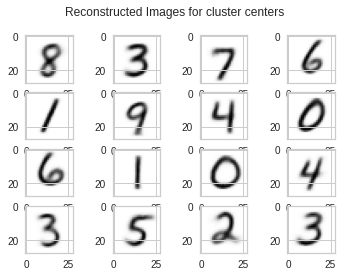

In [ ]:
# import cv2
# manual_annotation_json = None
# tf.reset_default_graph()
# # Cluster and decode the cluster center
# decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(
#                                                                                     MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
#                                                                                     16,
#                                                                                     latent_vectors,
#                                                                                     _exp_config,
#                                                                                     _exp_config.dao
#                                                                                     )
# display_images(decoded_images, None, "Reconstructed Images for cluster centers", 16)


# Code below this was not used from this notebook

In [ ]:
# # Investigate why 5 is wrong
# import json
# # TODO get the input from console or a gui app. For now edit the values directly here
# print("Getting manual_annotation")
# manual_annotation_json = dict()
# manual_annotation_json["manual_labels"] = [6, 1, 3, 4, 
#                                            0, 8, 2, 9,
#                                            7, 5
#                                           ]
# manual_annotation_json["manual_confidence"] = [1, 1, 0.9, 0.9,
#                                                1, 1, 1, 1,
#                                                1, 0.9
#                                               ]

# manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
# manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
# manual_annotation_json["posterior_proba"] = posterior_proba.tolist()


# manual_labels = manual_annotation_json["manual_labels"]
# manual_confidence = manual_annotation_json["manual_confidence"]
# posterior_proba = np.asarray(manual_annotation_json["posterior_proba"])
# df[cluster_column_name] = cluster_labels

In [ ]:

from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label, compute_distance, cluster_and_decode_latent_vectors_gmm

cluster_group_dict = get_cluster_groups(manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(_exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

NameError: ignored

In [ ]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 
level2_manual_annotations = cluster_next_level_gmm(_exp_config,
                                                   df,
                                                   cluster_column_name_2,
                                                   df[cluster_column_name],
                                                   model_type,
                                                   epochs_completed,
                                                   _exp_config.dao,
                                                   cluster_group_dict,
                                                   cluster_type="unknown_cluster"
                                                   )

(4083, 16)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(1212, 16)
(4393, 16)
(2216, 16)
(2339, 16)
(4154, 16)
(1664, 16)
(2155, 16)
(1915, 16)
(2360, 16)
Posterior probability shape (41877, 16)


ValueError: ignored

In [ ]:


# level_2_cluster_dict = level2_manual_annotations[2]
# level_2_cluster_dict["manual_labels"] = [
#                                          -1, -1,-1,-1,
#                                         -1,-1,-1,-1,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0,
#                                               0, 0, 0, 0,
#                                               0, 0
#                                               ]


# level_2_cluster_dict = level2_manual_annotations[5]
# level_2_cluster_dict["manual_labels"] = [-1,9,9,7,
#                                         9,9,9,-1,
#                                          9,9
#                                          ]

# level_2_cluster_dict["manual_confidences"] = [0, 0.9, 0.9, 0.7,
#                                               0.9, 0.9, 0.9, 0,
#                                               0.9, 0.9
#                                              ]


# level_2_cluster_dict = level2_manual_annotations[6]
# level_2_cluster_dict["manual_labels"] = [-1,-1,-1,-1,
#                                          -1,-1,-1,-1,
#                                          -1,-1
#                                          ]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0, 0,
#                                               0, 0, 0, 0,
#                                               0, 0
#                                              ]


#### 9 ###############################################
# level_2_cluster_dict = level2_manual_annotations[9]
# level_2_cluster_dict["manual_labels"] = [9,-1,-1,-1,
#                                          9,-1,9,9,
#                                          -1,-1
#                                          ]
# level_2_cluster_dict["manual_confidences"] =  [0.8,0, 0, 0,
#                                                0.8,0,0.8,0.8,
#                                                0,0
#                                                ]


# level_2_cluster_dict = level2_manual_annotations[8]
# level_2_cluster_dict["manual_labels"] = [-1, -1, 8, 8,
#                                         5, 5, 5, -1,
#                                         8,8
#                                          ]
# level_2_cluster_dict["manual_confidences"] = [0, 0, 0.9, 0.9,
#                                               0.7, 0.7, 0.7, 0,
#                                               0.9, 0.9
#                                              ]



# level_2_manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
#                                            f"level_2_manual_annotation_epoch_{epochs_completed}.json")

# with open(level_2_manual_annotation_file_json, "w") as json_file:
#     json.dump(level2_manual_annotations, json_file)


In [ ]:
print(f"Posterior probability shape {posterior_proba.shape}")
columns = []
for i in range(num_clusters):
    df[f"confidence_{i}"] = posterior_proba[:, i] 

In [ ]:
process_second_level_clusters(df,
                                  cluster_group_dict,
                                  level2_manual_annotations,
                                  z_col_names,
                                  cluster_column_name_2,
                              cluster_column_name
                              )
num_individual_samples_annotated = assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False,
                                   estimate_type="map"
                                  )
print(f"Total number of individual samples annotated {num_individual_samples_annotated}")

NameError: ignored

In [ ]:
plot_distance_distribution(df, [8], cluster_column_name, manual_labels)

NameError: ignored

In [ ]:
# Take samples from each distance - 0 ( cluster center), 0.5, 1, 1,5, 2, 2,5, 3, 3,5,......10]
# show sample images from each distance and manually decide the threshold
# Iterator over each distance from (0, 10, 0.5)
# comuter the cluster center and plot how much the cluster changes over each iteration
# Do one level of k-means clustring and look the good and bad cluster - compute the distance from level 1 cluser to each of level 2 cluster



In [ ]:
print([c.id for c in cluster_group_dict["good_clusters"].cluster_list])

NameError: ignored

In [ ]:
def get_cluster_groups(manual_labels,
                       manual_confidence,
                       cluster_column_name,
                       cluster_centers,
                       cluster_labels,
                       df,
                       parent_indices=None):
    """
    Create groups of clusters based on manual label given to each cluster. Different categories of cluster group are

    1. impure
    Contains impure clusters. impure cluster is a cluster where the cluster center have similarity with multiple labels,
    each with different confidence
    2. unknown
    The user who annotated the label doesn't know the label, or it is an invalid data for the domain under consideration
    3. similar_labels
    There are multiple clusters in the cluster group all of which has similar label

    4. good_clusters
    There are multiple clusters all with different labels each with a different confidence level greater than  threshold
    4. average_clusters
    There are multiple clusters all with different labels each with a different confidence level around 0.5
    5. low_confidence_clusters
    There are multiple clusters all with different labels each with a different confidence level close to zero
    """
    # annotation_string = "pure_cluster:Cluster number: {}\nCluster center label:{}\n Confidence: {}"

    cluster_groups_dict = dict()
    for cluster_num, cluster_center_label in enumerate(manual_labels):
        if parent_indices is None:
            _df = get_samples_for_cluster(df, cluster_num, cluster_column_name)
            indices = np.where(df[cluster_column_name].values == cluster_num)
        else:
            _df = get_samples_for_cluster(df.iloc[parent_indices], cluster_num, cluster_column_name)
            indices = np.where(df[cluster_column_name].iloc[parent_indices].values == cluster_num)

        cluster_details = {
            "cluster_centers": cluster_centers[cluster_num],
            "cluster_labels": cluster_labels,
            "indices": indices,  # Indices of this cluster elements in parent DataFrame
            "cluster_data_frame": _df,
            "whole_data_frame": df
        }
        if isinstance(cluster_center_label, tuple) or isinstance(cluster_center_label, list):
            # impure cluster
            # create an impure clusterGroup
            manual_annotation = ManualAnnotation(cluster_center_label,
                                                 manual_confidence[cluster_num])
            cluster = Cluster(cluster_id=cluster_num,
                              name=f"cluster_{cluster_num}",
                              cluster_details=cluster_details,
                              level=1,
                              manual_annotation=manual_annotation)
            if "impure_cluster" in cluster_groups_dict.keys():
                cluster_groups_dict["impure_cluster"].add_cluster(cluster)
            else:
                cluster_groups_dict["impure_cluster"] = ClusterGroup("impure_cluster", [cluster])
        elif cluster_center_label == -1:
            # unknown cluster
            manual_annotation = ManualAnnotation(cluster_center_label, manual_confidence[cluster_num])
            cluster = Cluster(cluster_id=cluster_num,
                              name=f"cluster_{cluster_num}",
                              cluster_details=cluster_details,
                              level=1,
                              manual_annotation=manual_annotation
                              )
            if "unknown_cluster" in cluster_groups_dict.keys():
                cluster_groups_dict["unknown_cluster"].add_cluster(cluster)
            else:
                cluster_groups_dict["unknown_cluster"] = ClusterGroup("unknown_cluster", [cluster])
            # unknown cluster
        else:
            # good/average/low confidence
            manual_annotation = ManualAnnotation(cluster_center_label, manual_confidence[cluster_num])
            cluster = Cluster(cluster_id=cluster_num,
                              name="cluster_".format(cluster_num),
                              cluster_details=cluster_details,
                              level=1,
                              manual_annotation=manual_annotation)
            print(cluster.id)
            cluster_group_label = manual_annotation.get_label()
            if cluster_group_label in cluster_groups_dict.keys():
                cluster_groups_dict[cluster_group_label].add_cluster(cluster)
            else:
                cluster_groups_dict[cluster_group_label] = ClusterGroup(cluster_group_label,
                                                                        [cluster])
    return cluster_groups_dict


In [ ]:
cluster_group_dict = get_cluster_groups(manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 
cluster_group_dict["good_clusters"].cluster_list


NameError: ignored

In [ ]:
MAX_IMAGES_TO_DISPLAY=36

In [ ]:
# images_by_label = dict()
# for i in range(10):
#     images_by_label[i] = train_images[train_labels == i]

In [ ]:
def get_digit_label(cluster_name:str):
    if cluster_name.startswith("level_2_cluster_centers"):
        cluster_id = int(cluster_name.rsplit("_", 1)[1])
        return manual_labels[cluster_id]
    elif cluster_name.startswith("training_set"):
        return int(cluster_name.rsplit("_", 1)[1])


In [ ]:
# -*- coding: utf-8 -*-
from __future__ import division

import json
import traceback
from typing import List
import os
import numpy as np
import pandas as pd

from clearn.config import ExperimentConfig
from clearn.config.common_path import get_encoded_csv_file
from clearn.dao.idao import IDao
from clearn.models.architectures.custom.tensorflow_graphs import cnn_n_layer, deconv_n_layer, fcnn_n_layer, \
    fully_deconv_n_layer
from clearn.models.generative_model import GenerativeModel
from clearn.utils import prior_factory as prior
from clearn.utils.retention_policy.policy import RetentionPolicy
from clearn.utils.utils import save_image, get_latent_vector_column, get_padding_info
from clearn.utils.dir_utils import get_eval_result_dir

import tensorflow as tf


class VAE(GenerativeModel):
    _model_name_ = "VAE"

    def __init__(self,
                 exp_config: ExperimentConfig,
                 sess,
                 epoch,
                 dao: IDao,
                 test_data_iterator=None,
                 read_from_existing_checkpoint=True,
                 check_point_epochs=None,
                 ):
        super().__init__(exp_config, sess, epoch, dao=dao, test_data_iterator=test_data_iterator)
        self.padding_added_row, self.padding_added_col, self.image_sizes = get_padding_info(exp_config,
                                                                                            dao.image_shape
                                                                                            )
        self.metrics_to_compute = ["reconstruction_loss"]
        self.metrics = dict()
        self.metrics[VAE.dataset_type_train] = dict()
        self.metrics[VAE.dataset_type_test] = dict()
        self.metrics[VAE.dataset_type_val] = dict()

        for metric in self.metrics_to_compute:
            self.metrics[VAE.dataset_type_train][metric] = []
            self.metrics[VAE.dataset_type_val][metric] = []
            self.metrics[VAE.dataset_type_test][metric] = []

        # test
        self.sample_num = 64  # number of generated images to be saved
        self.num_images_per_row = 4  # should be a factor of sample_num
        self.label_dim = dao.num_classes  # one hot encoding for 10 classes
        self.mu = tf.compat.v1.placeholder(tf.float32, [self.exp_config.BATCH_SIZE, self.exp_config.Z_DIM], name='mu')
        self.sigma = tf.compat.v1.placeholder(tf.float32, [self.exp_config.BATCH_SIZE, self.exp_config.Z_DIM],
                                              name='sigma')
        self.images = None
        self._build_model()
        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()
        self.sample_z = prior.gaussian(self.exp_config.BATCH_SIZE, self.exp_config.Z_DIM)
        self.counter, self.start_batch_id, self.start_epoch = self._initialize(read_from_existing_checkpoint,
                                                                               check_point_epochs)
        self.num_training_epochs_completed = self.start_epoch
        self.num_steps_completed = self.start_batch_id

    #   Gaussian Encoder
    def _encoder(self, x, reuse=False):
        print("Encoding")
        if self.exp_config.fully_convolutional:
            gaussian_params = fcnn_n_layer(self, x, self.exp_config.num_units, 2, reuse)
        else:
            gaussian_params = cnn_n_layer(self, x, 2 * self.exp_config.Z_DIM, reuse)
        # The mean parameter is unconstrained

        mean = gaussian_params[:, :self.exp_config.Z_DIM]
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:, self.exp_config.Z_DIM:])
        return mean, stddev

    # Bernoulli decoder
    def _decoder(self, z, reuse=False):
        print("Decoding")
        if self.exp_config.fully_convolutional:
            out = fully_deconv_n_layer(self,
                                       z,
                                       self.exp_config.num_units,
                                       self.dao.image_shape[2],
                                       1,
                                       reuse)
        else:
            out = deconv_n_layer(self, z, self.dao.image_shape[2], reuse)
        return out

    def inference(self):
        z = self.mu + self.sigma * tf.random_normal(tf.shape(self.mu), 0, 1, dtype=tf.float32)
        self.images = self._decoder(z, reuse=True)

    def _build_model(self):
        # some parameters
        image_dims = self.dao.image_shape
        bs = self.exp_config.BATCH_SIZE

        """ Graph Input """
        # images
        self.inputs = tf.compat.v1.placeholder(tf.float32, [bs] + list(image_dims), name='real_images')

        # random vectors with  multi-variate gaussian distribution
        # 0 mean and covariance matrix as Identity
        # self.standard_normal = tf.compat.v1.placeholder(tf.float32, [bs, self.exp_config.Z_DIM], name='z')

        """ Encode the input """
        self.mu, self.sigma = self._encoder(self.inputs, reuse=False)

        # sampling by re-parameterization technique
        self.z = self.mu + self.sigma * tf.random.normal(tf.shape(self.mu), 0, 1, dtype=tf.float32)

        # decoding
        out = self._decoder(self.z, reuse=False)

        # loss
        if self.exp_config.activation_output_layer == "SIGMOID":
            self.out = tf.clip_by_value(out, 1e-8, 1 - 1e-8)

            self.marginal_likelihood = tf.reduce_sum(self.inputs * tf.math.log(self.out) +
                                                     (1 - self.inputs) * tf.math.log(1 - self.out),
                                                     [1, 2],
                                                     )
        else:
            # Linear activation
            self.out = out
            mll = tf.compat.v1.losses.mean_squared_error(self.inputs,
                                                         self.out,
                                                         reduction=tf.compat.v1.losses.Reduction.NONE
                                                         )

            mse_for_all_images = -tf.compat.v1.reduce_mean(mll, axis=(1, 2, 3))
            self.marginal_likelihood = tf.math.multiply(mse_for_all_images,
                                                         self.mask_for_concept_no[6][-1])

        self.neg_loglikelihood = -tf.reduce_mean(self.marginal_likelihood)

        kl = 0.5 * tf.reduce_sum(tf.square(self.mu) +
                                 tf.square(self.sigma) -
                                 tf.math.log(1e-8 + tf.square(self.sigma)) - 1, [1])

        self.KL_divergence = tf.reduce_mean(kl)
        self.compute_and_optimize_loss()

    def compute_and_optimize_loss(self):
        # evidence_lower_bound = -self.neg_loglikelihood - self.exp_config.beta * self.KL_divergence
        self.loss = self.neg_loglikelihood + self.exp_config.beta * self.KL_divergence

        """ Training """
        # optimizers
        t_vars = tf.trainable_variables()
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.optim = tf.train.AdamOptimizer(self.exp_config.learning_rate, beta1=self.exp_config.beta1_adam) \
                .minimize(self.loss, var_list=t_vars)

        """" Testing """

        # for test
        # self.fake_images = self._decoder(self.standard_normal, reuse=True)

        """ Summary """
        tf.summary.scalar("Negative Log Likelihood", self.neg_loglikelihood)
        tf.summary.scalar("K L Divergence", self.KL_divergence)
        tf.summary.scalar("Total Loss", self.loss)

        # final summary operations
        self.merged_summary_op = tf.summary.merge_all()

    def get_trainable_vars(self):
        return tf.trainable_variables()

    def train(self, train_val_data_iterator):
        start_batch_id = self.start_batch_id
        start_epoch = self.start_epoch
        self.num_batches_train = train_val_data_iterator.get_num_samples("train") // self.exp_config.BATCH_SIZE
        evaluation_run_for_last_epoch = False
        for epoch in range(start_epoch, self.epoch):
            # get batch data
            mean_nll = 0
            num_samples_processed = 0
            for batch in range(start_batch_id, self.num_batches_train):
                # first 10 elements of manual_labels is actual one hot encoded labels
                # and next value is confidence
                batch_images, _, manual_labels, _ = train_val_data_iterator.get_next_batch("train")
                if batch_images.shape[0] < self.exp_config.BATCH_SIZE:
                    break
                batch_z = prior.gaussian(self.exp_config.BATCH_SIZE, self.exp_config.Z_DIM)

                # update autoencoder
                _, summary_str, loss, nll_loss, kl_loss, marginal_ll = self.sess.run([self.optim,
                                                                                      self.merged_summary_op,
                                                                                      self.loss,
                                                                                      self.neg_loglikelihood,
                                                                                      self.KL_divergence,
                                                                                      self.marginal_likelihood
                                                                                      ],
                                                                                     feed_dict={
                                                                                         self.inputs: batch_images
                                                                                     })
                marginal_ll = -marginal_ll
                sum_nll_batch = np.mean(marginal_ll) * self.exp_config.BATCH_SIZE
                mean_nll = (mean_nll * num_samples_processed + sum_nll_batch) / (
                        num_samples_processed + self.exp_config.BATCH_SIZE)
                self.counter += 1
                self.num_steps_completed = batch + 1
                num_samples_processed = self.num_steps_completed * self.exp_config.BATCH_SIZE
                # print(f"Epoch:{epoch} Batch:{batch}  loss={loss} nll={nll_loss} kl_loss={kl_loss} batch_mean_nll={np.mean(marginal_ll)}  overall_mean_nll={mean_nll} Number of samples completed ={num_samples_processed}")

                # self.writer.add_summary(summary_str, self.counter - 1)
            self.num_training_epochs_completed = epoch + 1
            print(f"Completed {self.num_training_epochs_completed} epochs")
            if self.exp_config.run_evaluation_during_training:
                if np.mod(epoch, self.exp_config.eval_interval_in_epochs) == 0:
                    train_val_data_iterator.reset_counter("train")
                    train_val_data_iterator.reset_counter("val")
                    self.evaluate(train_val_data_iterator, "train")
                    self.evaluate(train_val_data_iterator, "val")
                    if self.test_data_iterator is not None:
                        self.evaluate(self.test_data_iterator, dataset_type="test")
                        self.test_data_iterator.reset_counter("test")
                    for metric in self.metrics_to_compute:
                        print(f"{metric}: train: {self.metrics[VAE.dataset_type_train][metric][-1]}")
                        print(f"{metric}: val: {self.metrics[VAE.dataset_type_val][metric][-1]}")
                        print(f"{metric}: test: {self.metrics[VAE.dataset_type_test][metric][-1]}")

                    evaluation_run_for_last_epoch = True

            train_val_data_iterator.reset_counter("train")
            train_val_data_iterator.reset_counter("val")

            if self.num_batches_train > start_batch_id:
                print(f"Epoch:{epoch}   loss={loss} nll={nll_loss} kl_loss={kl_loss}")
            # After an epoch, start_batch_id is set to zero
            # non-zero value is only for the first epoch after loading pre-trained model
            start_batch_id = 0

            train_val_data_iterator.reset_counter("train")
            if np.mod(epoch, self.exp_config.model_save_interval) == 0:
                print("Saving check point", self.exp_config.TRAINED_MODELS_PATH)
                self.save(self.exp_config.TRAINED_MODELS_PATH, self.counter)
        train_val_data_iterator.reset_counter("val")
        train_val_data_iterator.reset_counter("train")
        if not evaluation_run_for_last_epoch:
            self.evaluate(data_iterator=train_val_data_iterator,
                          dataset_type="val")
            self.evaluate(data_iterator=train_val_data_iterator,
                          dataset_type="train")
            if self.test_data_iterator is not None:
                self.test_data_iterator.reset_counter("test")
                self.evaluate(self.test_data_iterator, dataset_type="test")
                self.test_data_iterator.reset_counter("test")

        # save metrics
        self.save_metrics()

    def save_metrics(self):
        df = None
        for metric in self.metrics_to_compute:
            if len(self.metrics["train"][metric]) == 0:
                continue
            df = pd.DataFrame(np.asarray(self.metrics["train"][metric])[:, 0], columns=["epoch"])
            df[f"train_{metric}_mean"] = np.asarray(self.metrics["train"][metric])[:, 1]
            df[f"val_{metric}_mean"] = np.asarray(self.metrics["val"][metric])[:, 1]
            df[f"test_{metric}_mean"] = np.asarray(self.metrics["test"][metric])[:, 1]
            if np.asarray(self.metrics["val"][metric]).shape[1] == 3:
                df[f"train_{metric}_std"] = np.asarray(self.metrics["train"][metric])[:, 2]
                df[f"val_{metric}_std"] = np.asarray(self.metrics["val"][metric])[:, 2]
                df[f"test_{metric}_std"] = np.asarray(self.metrics["test"][metric])[:, 2]

            df.to_csv(os.path.join(self.exp_config.ANALYSIS_PATH, f"{metric}_{self.num_training_epochs_completed}.csv"),
                      index=False)
            max_value = df[f"test_{metric}_mean"].max()
            print(f"Max test {metric}", max_value)
            min_value = df[f"test_{metric}_mean"].min()
            print(f"Min test {metric}", min_value)

    def evaluate(self, data_iterator, dataset_type="train", num_batches_train=0, save_images=True,
                 metrics=[],
                 save_policies=("TEST_TOP_128", "TEST_BOTTOM_128",
                                "TRAIN_TOP_128", "TRAIN_BOTTOM_128",
                                "VAL_TOP_128", "VAL_BOTTOM_128")
                 ):
        if metrics is None or len(metrics) == 0:
            metrics = self.metrics_to_compute
        print(
            f"Running evaluation after epoch:{self.num_training_epochs_completed} and step:{self.num_steps_completed} ")
        start_eval_batch = 0
        num_eval_batches = data_iterator.get_num_samples(dataset_type) // self.exp_config.BATCH_SIZE
        mu = None
        sigma = None
        z = None
        data_iterator.reset_counter(dataset_type)
        reconstruction_losses = None
        retention_policies: List[RetentionPolicy] = list()
        if save_images:
            for policy in save_policies:
                if dataset_type.upper() == policy.split("_")[0]:
                    policy_type = policy.split("_")[1]
                    if "reconstruction_loss" in metrics:
                        rp = RetentionPolicy(dataset_type.upper(),
                                             policy_type=policy_type,
                                             N=int(policy.split("_")[2])
                                             )
                        retention_policies.append(rp)
        for batch_no in range(start_eval_batch, num_eval_batches):
            batch_images, batch_labels, manual_labels, _ = data_iterator.get_next_batch(dataset_type)
            # skip last batch
            if batch_images.shape[0] < self.exp_config.BATCH_SIZE:
                data_iterator.reset_counter(dataset_type)
                break
            batch_z = prior.gaussian(self.exp_config.BATCH_SIZE, self.exp_config.Z_DIM)

            reconstructed_image, summary, mu_for_batch, sigma_for_batch, z_for_batch, nll, nll_batch = self.sess.run(
                [self.out,
                 self.merged_summary_op,
                 self.mu,
                 self.sigma,
                 self.z,
                 self.neg_loglikelihood,
                 self.marginal_likelihood
                 ],
                feed_dict={
                    self.inputs: batch_images
                })
            nll_batch = -nll_batch
            if len(nll_batch.shape) == 0:
                data_iterator.reset_counter(dataset_type)
                print(f"Skipping batch {batch_no}. Investigate and fix this issue later")
                print(
                    f"Length of batch_images: {batch_images.shape} Nll_batch shape: {nll_batch.shape} Nll shape: {nll.shape} Nll:{nll} ")
                break
            # if len(nll_batch.shape) != 2:
            #     raise Exception(f"Shape of nll_batch {nll_batch.shape}")

            """
            Update priority queues for keeping top and bottom N samples for all the required metrics present save_policy
            """
            if save_images:
                try:
                    for rp in retention_policies:
                        rp.update_heap(cost=nll_batch,
                                       exp_config=self.exp_config,
                                       data=[reconstructed_image, np.argmax(batch_labels, axis=1), nll_batch, batch_images])
                except:
                    print(f"Shape of mse is {nll_batch.shape}")
                    traceback.print_exc()
            if reconstruction_losses is None:
                reconstruction_losses = nll_batch
            else:
                reconstruction_losses = np.hstack([reconstruction_losses, nll_batch])
            if self.exp_config.return_latent_vector:
                if z is None:
                    mu = mu_for_batch
                    sigma = sigma_for_batch
                    z = z_for_batch
                else:
                    mu = np.vstack([mu, mu_for_batch])
                    sigma = np.hstack([sigma, sigma_for_batch])
                    z = np.vstack([z, z_for_batch])

        if "reconstruction_loss" in self.metrics_to_compute:
            reconstruction_loss = np.mean(reconstruction_losses)
            self.metrics[dataset_type]["reconstruction_loss"].append(
                [self.num_training_epochs_completed, reconstruction_loss, np.std(reconstruction_losses)])

        if save_images:
            self.save_sample_reconstructed_images(dataset_type, retention_policies)

        data_iterator.reset_counter(dataset_type)

        encoded_df = pd.DataFrame(reconstruction_losses,
                                  columns=["reconstruction_loss"])
        if self.exp_config.return_latent_vector:
            mean_col_names, sigma_col_names, z_col_names, l3_col_names = get_latent_vector_column(self.exp_config.Z_DIM)
            encoded_df = pd.DataFrame(mu, columns=mean_col_names)
            for i, sigma_col_name in enumerate(sigma_col_names):
                encoded_df[sigma_col_name] = sigma[:, i]

            for i, z_col_name in enumerate(z_col_names):
                encoded_df[z_col_name] = z[:, i]
        print("Write predictions", self.exp_config.write_predictions)
        if self.exp_config.write_predictions:
            output_csv_file = get_encoded_csv_file(self.exp_config,
                                                   self.num_training_epochs_completed,
                                                   dataset_type
                                                   )
            print("Saving evaluation results to ", self.exp_config.ANALYSIS_PATH)
            encoded_df.to_csv(os.path.join(self.exp_config.ANALYSIS_PATH, output_csv_file), index=False)

        return encoded_df

    def save_sample_reconstructed_images(self, dataset_type, retention_policies):
        reconstructed_dir = get_eval_result_dir(self.exp_config.PREDICTION_RESULTS_PATH,
                                                self.num_training_epochs_completed,
                                                self.num_steps_completed)
        num_samples_per_image = 64
        manifold_w = 4
        manifold_h = num_samples_per_image // manifold_w
        for rp in retention_policies:
            num_images = rp.N // num_samples_per_image
            if dataset_type.upper() == rp.data_type.upper():
                for image_no in range(num_images):
                    file_image = f"{dataset_type}_{rp.policy_type}_{image_no}.png"
                    file_label = f"{dataset_type}_{rp.policy_type}_{image_no}_labels.json"
                    file_loss = f"{dataset_type}_{rp.policy_type}_{image_no}_loss.json"
                    samples_to_save = np.zeros((num_samples_per_image,
                                                self.dao.image_shape[0],
                                                self.dao.image_shape[1],
                                                self.dao.image_shape[2]))
                    labels = np.zeros(num_samples_per_image)
                    losses = np.zeros(num_samples_per_image)
                    for sample_num, e in enumerate(rp.data_queue[image_no * num_samples_per_image: (
                                                                                                           image_no + 1) * num_samples_per_image]):
                        samples_to_save[sample_num, :, :, :] = e[2][0]
                        labels[sample_num] = e[2][1]
                        losses[sample_num] = e[2][2]
                    save_image(samples_to_save, [manifold_h, manifold_w], reconstructed_dir + file_image)

                    with open(reconstructed_dir + file_label, "w") as fp:
                        json.dump(labels.tolist(), fp)

                    with open(reconstructed_dir + file_loss, "w") as fp:
                        json.dump(losses.tolist(), fp)

    @property
    def model_dir(self):
        return "{}_{}_{}_{}".format(
            self._model_name_, self.exp_config.dataset_name,
            self.exp_config.BATCH_SIZE, self.exp_config.Z_DIM)

    def encode(self, images):
        mu, sigma, z = self.sess.run([self.mu, self.sigma, self.z],
                                     feed_dict={self.inputs: images})
        return mu, sigma, z

    def get_decoder_weights_bias(self):
        if self.exp_config.fully_convolutional:
            num_deconv_layers = len(self.exp_config.num_units)
        else:
            num_deconv_layers = len(self.exp_config.num_units) - self.exp_config.num_dense_layers
        param_names=[]
        for layer_num in range(num_deconv_layers):
            param_names.append(f"decoder/de_conv_{layer_num}/w:0")
            param_names.append(f"decoder/de_conv_{layer_num}/biases:0")
        param_names.append("decoder/de_out/w:0")
        param_names.append("decoder/de_out/biases:0")

        default_graph = tf.get_default_graph()
        params = [default_graph.get_tensor_by_name(tn) for tn in param_names]
        param_values = self.sess.run(params)
        return {tn: tv for tn, tv in zip(param_names, param_values)}

    def get_encoder_weights_bias(self):
        name_w_1 = "encoder/en_conv1/w:0"
        name_w_2 = "encoder/en_conv2/w:0"
        name_w_3 = "encoder/en_fc3/Matrix:0"
        name_w_4 = "encoder/en_fc4/Matrix:0"

        name_b_1 = "encoder/en_conv1/biases:0"
        name_b_2 = "encoder/en_conv2/biases:0"
        name_b_3 = "encoder/en_fc3/bias:0"
        name_b_4 = "encoder/en_fc4/bias:0"

        layer_param_names = [name_w_1,
                             name_b_1,
                             name_w_2,
                             name_b_2,
                             name_w_3,
                             name_b_3,
                             name_w_4,
                             name_b_4
                             ]

        default_graph = tf.get_default_graph()
        params = [default_graph.get_tensor_by_name(tn) for tn in layer_param_names]
        param_values = self.sess.run(params)
        return {tn: tv for tn, tv in zip(layer_param_names, param_values)}

    def get_encoder_features_list(self):
        feature_list = []
        feature_names = []
        for key, value in self.encoder_dict.items():
            feature_names.append(key)
            feature_list.append(value)
        return feature_names, feature_list


    def encode_and_get_features(self, images: np.ndarray):
        features_list = [self.mu, self.sigma, self.z]
        hidden_feature_names, hidden_features = self.get_encoder_features_list()
        features_list.extend(hidden_features)

        encoded_features = self.sess.run(features_list,
                                                       feed_dict={self.inputs: images
                                                                  })

        return hidden_feature_names, encoded_features[0], encoded_features[1], encoded_features[2], encoded_features[3:]

    def get_decoder_features_list(self):
        feature_list = []
        feature_names = []
        for key, value in self.decoder_dict.items():
            feature_names.append(key)
            feature_list.append(value)
        return feature_names, feature_list

    def decode_and_get_features(self, z: np.ndarray):
        features_list = [self.out]
        hidden_feature_names, hidden_features = self.get_decoder_features_list()
        features_list.extend(hidden_features)
        decoded_features = self.sess.run(features_list,
                                         feed_dict={self.z: z
                                                    }
                                         )

        return hidden_feature_names, decoded_features

    def decode(self, z):
        images = self.sess.run(self.out, feed_dict={self.z: z})
        return images

    def decode_l3(self, z):
        images = self.sess.run(self.out, feed_dict={self.dense2_en: z})
        return images

    def decode_layer1(self, z):
        batch_z = prior.gaussian(self.exp_config.BATCH_SIZE, self.exp_config.Z_DIM)
        dense1_de = self.sess.run(self.dense1_de, feed_dict={self.z: z
                                                             })
        return dense1_de

    def load_from_checkpoint(self):
        # initialize all variables
        tf.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.sample_z = prior.gaussian(self.exp_config.BATCH_SIZE, self.exp_config.Z_DIM)

        # restore check-point if it exits
        could_load, checkpoint_counter = self._load(self.exp_config.TRAINED_MODELS_PATH)
        if could_load:
            print(" [*] Load SUCCESS")
        else:
            print(" [!] Load failed...")
        return checkpoint_counter


ModuleNotFoundError: ignored

In [ ]:
from clearn.models.generative_model import GenerativeModel
def decode_and_get_features(model: GenerativeModel, z: np.ndarray, batch_size: int):
    feature_dimension = [len(z), model.dao.image_shape[0], model.dao.image_shape[1], model.dao.image_shape[2]]
    reconstructed_images = np.zeros(feature_dimension)
    num_latent_vectors = z.shape[0]
    num_batches = num_latent_vectors // batch_size
    dense1_des = []
    dense2_des = []
    reshaped_des = []
    deconv1_des = []
    features_dict = dict()
    for batch_num in range(num_batches):
        feature_names, decoded_images_and_features = model.decode_and_get_features(z[batch_num * batch_size: (batch_num + 1) * batch_size])
        reconstructed_images[batch_num * batch_size: (batch_num + 1) * batch_size] = decoded_images_and_features[0]
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                print(decoded_images_and_features[i + 1].shape)
                features_dict[feature_name] = np.zeros([len(z),
                                                       decoded_images_and_features[i + 1].shape[1],
                                                       decoded_images_and_features[i + 1].shape[2],
                                                       decoded_images_and_features[i + 1].shape[3]]
                                                       )
            features_dict[feature_name][batch_num * batch_size: (batch_num + 1) * batch_size] = decoded_images_and_features[i + 1]

    left_out = num_latent_vectors % batch_size
    if left_out > 0:
        last_batch = np.zeros([batch_size, z.shape[1]])
        last_batch[0:left_out, :] = z[num_batches * batch_size:]
        feature_names, decoded_images_and_features = model.decode_and_get_features(last_batch)
        reconstructed_images[num_batches * batch_size:] = decoded_images_and_features[0][0:left_out]
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                features_dict[feature_name] = np.zeros([len(z),
                                                       decoded_images_and_features[i + 1].shape[1],
                                                       decoded_images_and_features[i + 1].shape[2],
                                                       decoded_images_and_features[i + 1].shape[3]]
                                                       )
            features_dict[feature_name][num_batches * batch_size:] = decoded_images_and_features[i + 1][0:left_out]

        
    return feature_names, reconstructed_images, features_dict

In [ ]:
def encode_and_get_features(model: SemiSupervisedClassifierMnist,
                            images, batch_size, z_dim):
    num_images = images.shape[0]
    num_batches = num_images // batch_size
    mus = np.zeros([len(images), z_dim])
    sigmas = np.zeros([len(images), z_dim])
    latent_vectors = np.zeros([len(images), z_dim])
    features_dict = dict()

    for batch_num in range(num_batches):
        feature_names, mu, sigma, z, encoded_features = model.encode_and_get_features(
            images[batch_num * batch_size: (batch_num + 1) * batch_size])
        mus[batch_num * batch_size: (batch_num + 1) * batch_size] = mu
        sigmas[batch_num * batch_size: (batch_num + 1) * batch_size] = sigma
        latent_vectors[batch_num * batch_size: (batch_num + 1) * batch_size] = z
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                print(encoded_features[i].shape)
                features_dict[feature_name] = np.zeros([len(z),
                                                       encoded_features[i].shape[1],
                                                       encoded_features[i].shape[2],
                                                       encoded_features[i].shape[3]]
                                                       )
            features_dict[feature_name][batch_num * batch_size: (batch_num + 1) * batch_size] = encoded_features[i]


    left_out = num_images % batch_size
    if left_out > 0:
        feature_dimension = [batch_size, model.dao.image_shape[0], model.dao.image_shape[1], model.dao.image_shape[2]]
        last_batch = np.zeros(feature_dimension)
        last_batch[0:left_out] = images[num_batches * batch_size:]
        feature_names, mu, sigma, z, encoded_features = model.encode_and_get_features(last_batch)
        mus[num_batches * batch_size:] = mu[0:left_out]
        sigmas[num_batches * batch_size:] = sigma[0:left_out]
        latent_vectors[num_batches * batch_size:] = z[0:left_out]
        for i, feature_name in enumerate(feature_names):
            if feature_name not in features_dict:
                print(encoded_features[i].shape)
                features_dict[feature_name] = np.zeros([len(z),
                                                       encoded_features[i].shape[1],
                                                       encoded_features[i].shape[2],
                                                       encoded_features[i].shape[3]]
                                                       )
            features_dict[feature_name][num_batches * batch_size:] = encoded_features[i]

        

    return mus, sigmas, latent_vectors, features_dict


# Result of clustering latent vectors (encoder output) of visual concepts and decoding the cluster centers


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Encoding
Decoding
layer_num 3 de_conv_3
(512, 14, 14, 256)
(512, 14, 14, 256)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 10
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 11
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 12
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 13
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 14
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 15
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 16
input shape  (512

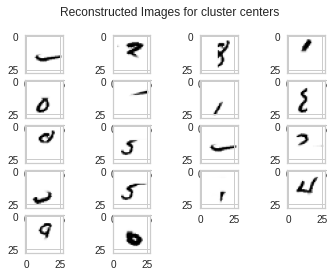

In [ ]:
import cv2
manual_annotation_json = None
tf.reset_default_graph()
# Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(
                                                                                    MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    18,
                                                                                    latent_vectors_visual_concepts,
                                                                                    _exp_config,
                                                                                    _exp_config.dao
                                                                                    )
display_images(decoded_images, None, "Reconstructed Images for cluster centers", 18)


*italicised text*

In [ ]:



import cv2
manual_annotation_json = None
tf.reset_default_graph()
# Cluster and decode the cluster center

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          latent_vectors_visual_concepts,
                                                          _exp_config.BATCH_SIZE
                                                          )
    


feature_names, reconstructed_imges, feature_dict  = decode_and_get_features(model, latent_vectors_visual_concepts, exp_config.BATCH_SIZE)
print([k for k in feature_dict.keys()])
#layer3_featuremaps_visual_concepts = feature_dict[]
print(layer3_featuremaps_visual_concepts.shape)
# decoded_images, cluster_centers, cluster_labels, posterior_proba = cluster_and_decode_latent_vectors_gmm(
#                                                                                     MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
#                                                                                     18,
#                                                                                     layer3_featuremaps_visual_concepts,
#                                                                                     _exp_config,
#                                                                                     _exp_config.dao
#                                                                                     )
# display_images(decoded_images, None, "Reconstructed Images for cluster centers", 18)


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 512), (14, 14, 256), (7, 7, 256), (7, 7, 128), (4, 4, 64), 16]
[512, 256, 256, 128, 64]
Encoding
Decoding
layer_num 3 de_conv_3
(512, 14, 14, 256)
(512, 14, 14, 256)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 10
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 11
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 12
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 13
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 14
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 15
input shape  (512, 14, 14, 1)
feature shape (512, 14, 14, 256)
Computing loss for 3 concept 16
input shape  (512

# Start segmentation
## Criteria for manual selection
*  Image is straight and vertical
*  All all features clearyly vision

In [ ]:
manual_label_to_cluster_id_map = dict()

for manual_label in manual_labels:
    level_1_clluster = np.where(np.asarray(manual_labels) == manual_label)
    cluster_id = level_1_clluster[0][0]
    manual_label_to_cluster_id_map[manual_label] = cluster_id


In [ ]:
level2_manual_annotations_good_cluster:Dict[int, Dict] = dict()
level2_manual_annotations_good_cluster = cluster_next_level_gmm(_exp_config,
                                                df,
                                                cluster_column_name_2,
                                                df[cluster_column_name],
                                                model_type,
                                                epochs_completed,
                                                _exp_config.dao,
                                                cluster_group_dict,
                                                cluster_type="good_clusters",
                                                num_clusters=20,
                                                show_images=False
                                                )

0 6
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

1 1
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

2 3
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

3 4
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

4 0
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

5 8
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

6 2
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

7 9
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

8 7
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

9 5
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_check

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
image_set_dict = dict()
for cluster_id in range(num_clusters):
    image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = np.asarray(level2_manual_annotations_good_cluster[cluster_id]["decoded_images"])
    image_set_dict[f"training_set_{cluster_id}"] = images_by_label[cluster_id]


In [ ]:
image_list:Dict[int, np.ndarray] = dict()
image_segments:Dict[int, np.ndarray] = dict()

## Digit 8

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


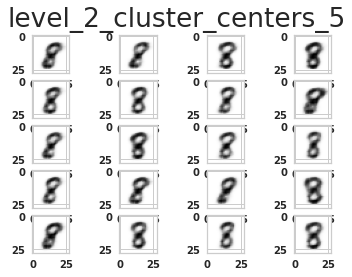

Number of image is 5837. Displaying only first 36 images 


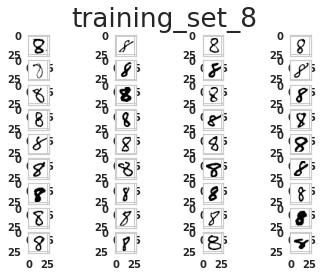

In [ ]:
digit = 8
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 2
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
h_extend = [ 13, 26]
v_extend = [0,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = [ 0, 15]
v_extend = [0,28]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = []
v_extend = [13, 28]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_expted = [ ]
v_extend = [0, 13]

if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 4
7
Image shape (28, 28, 1)
[13, 26] [0, 28] (28, 28, 1)
13 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
7
Image shape (28, 28, 1)
[0, 15] [0, 28] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [13, 28] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [0, 13] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_8.png


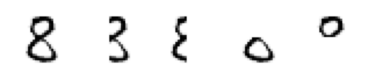

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 7

Number of image is 6248. Displaying only first 36 images 


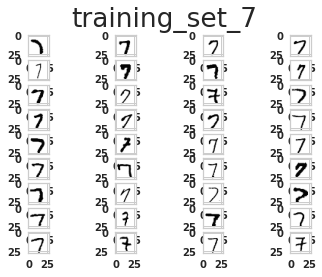

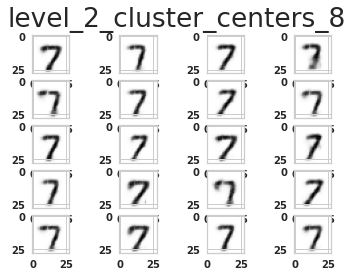

In [ ]:
digit = 7
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
start_index = 0
offset = 2
sample_index = start_index + offset
# cluster_name = "training_set"
#if choosing from cluster, chnage the digit

cluster_name = f"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"

digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
h_extend = [ ]
v_extend = [0, 12]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
h_extend = [ ]
v_extend = [12, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [0, 12] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [12, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_7.png


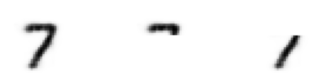

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 6

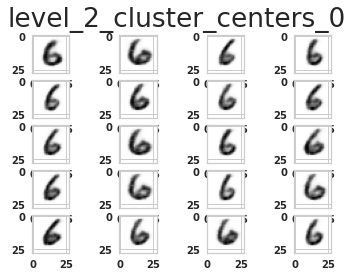

Number of image is 5903. Displaying only first 36 images 


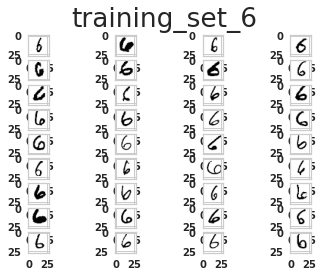

In [ ]:
digit = 6
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )


In [ ]:
offset = 3
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
# image_segments = segment( digit_image, h_extend = [ ], v_extend = [0,12], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#                         cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [0, 12]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [12,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,                cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [12,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [0, 12] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [12, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_6.png


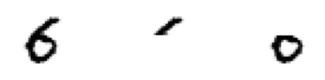

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 5

Number of image is 5405. Displaying only first 36 images 


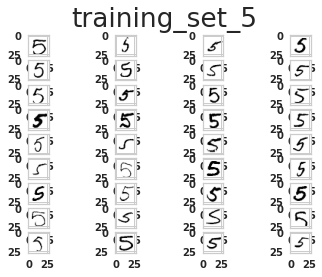

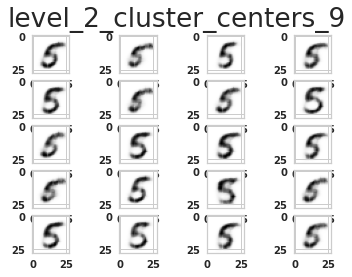

In [ ]:
digit = 5
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 4
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [5, 11], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#                               cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [5, 11]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
# image_segments = segment( digit_image, h_extend = [ ], v_extend = [11, 28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,                        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [11,28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 11] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [11, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_5.png


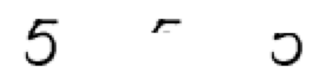

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 4

### 4 has bimodel distribution. So take two samples from each mode

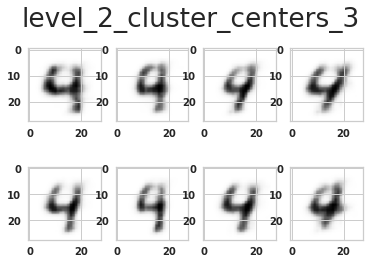

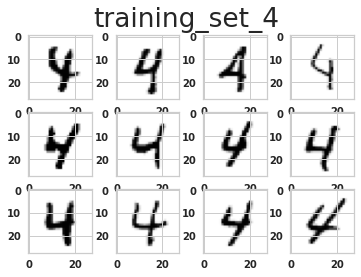

In [ ]:
digit = 4
start_index = 12
NUM_IMAGES_IN_SINGLE_PLOT = 12
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set[start_index:start_index + NUM_IMAGES_IN_SINGLE_PLOT],
                   None,
                   cluster_name
                   )

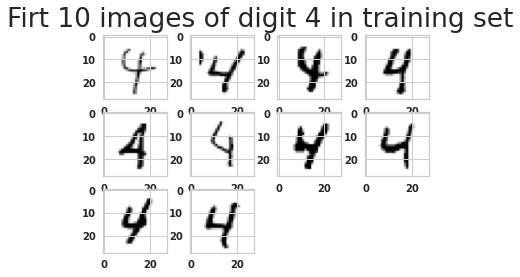

In [ ]:
display_images(images_by_label[digit][10:20,:,:,:], None, f"Firt 10 images of digit {digit} in training set", 10)

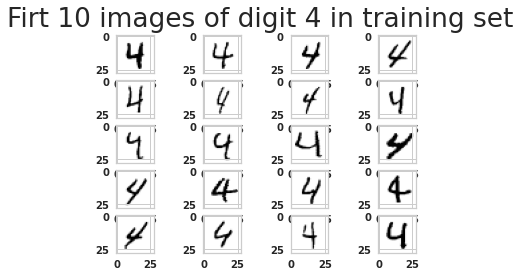

In [ ]:
start_index = 20
display_images(images_by_label[digit][start_index:40,:,:,:], None, f"Firt 10 images of digit {digit} in training set")

In [ ]:
offset = 1
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [15, 18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [15, 18]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
# left veritical line
#image_segments = segment( digit_image, h_extend = [13,16 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config, cluster=cluster_name, sample_index=sample_index)

h_extend = [13, 16]
v_extend = []
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
# middle veritical line
# image_segments = segment( digit_image, h_extend = [14,17 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config, cluster=cluster_name, sample_index=sample_index)

h_extend = [14,17 ]
v_extend = []
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 3
7
Image shape (28, 28, 1)
[0, 28] [15, 18] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[13, 16] [0, 28] (28, 28, 1)
13 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
7
Image shape (28, 28, 1)
[14, 17] [0, 28] (28, 28, 1)
14 14.0 5.6000000000000005
Starts from middle on horizontal axis
Starts from top on vertical axis
28 25.2
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_4_training_set_4_21.png


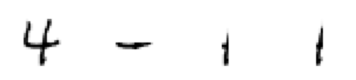

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

### 2nd mode of 4

In [ ]:
#Cleare the previsous image result of 4
image_list[digit] = []

<Figure size 432x288 with 0 Axes>

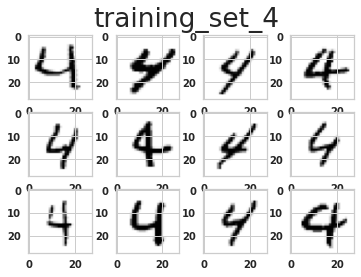

In [ ]:
start_index = 30
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set[start_index:start_index + NUM_IMAGES_IN_SINGLE_PLOT],
                   None,
                   cluster_name
                   )

In [ ]:
offset = 9
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [ ], v_extend = [5,18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name,
#        sample_index=sample_index)

h_extend = [ ]
v_extend = [5, 17]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
# image_segments = segment( digit_image, h_extend = [ 17,23 ], v_extend = [], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name,
#        sample_index=sample_index)

h_extend = [ 17, 23]
v_extend = [17, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 17] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[17, 23] [17, 28] (28, 28, 1)
17 14.0 5.6000000000000005
Starts from middle on horizontal axis
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_4_training_set_4_39.png


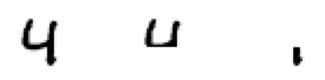

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 3

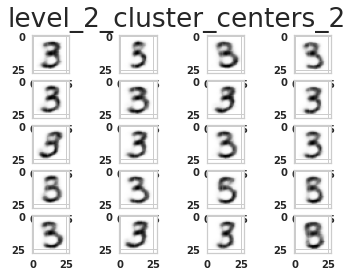

Number of image is 6117. Displaying only first 36 images 


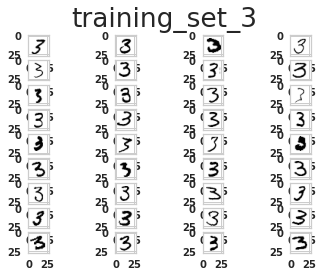

In [ ]:
digit = 3
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 6
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [5,16], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [5, 16]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [16,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [16, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [5, 16] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [16, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_3.png


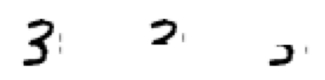

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 2

Number of image is 5940. Displaying only first 36 images 


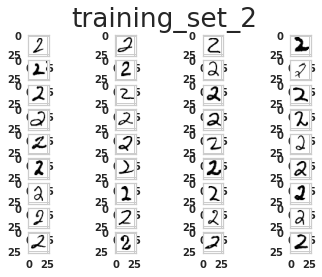

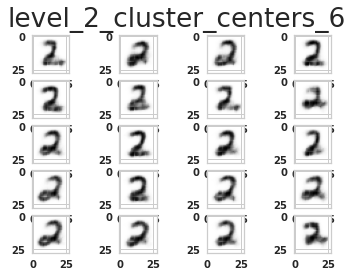

In [ ]:
digit = 2
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

### 2 is bimodal

In [ ]:
offset = 5
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [3,18], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

# Looks like a hook, question mark with dot removed

h_extend = [ ]
v_extend = [3, 18]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [18,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [18, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 18] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [18, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_2_training_set_2_5.png


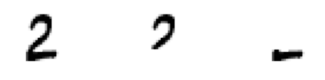

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

### 2nd mode of 2

In [ ]:
#Cleare the previsous image result of 2
image_list[digit] = []

Number of image is 5940. Displaying only first 10 images 


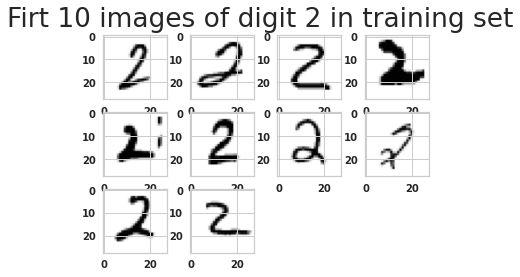

In [ ]:
display_images(images_by_label[digit], None, f"Firt 10 images of digit {digit} in training set", 10)

In [ ]:
offset = 6
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 

In [ ]:
# image_segments = segment( digit_image,
#         h_extend = [],
#         v_extend = [3,15],
#         digit = digit,
#         num_clusters=num_clusters ,
#         exp_config=_exp_config,
#         cluster=cluster_name,
#         sample_index=sample_index
#         )

h_extend = [ ]
v_extend = [3,15]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])
    

In [ ]:
# image_segments = segment( digit_image,
#                          h_extend = [],
#                          v_extend = [15, 28],
#                          digit = digit,
#                          num_clusters=num_clusters,
#                          exp_config=_exp_config,
#                          cluster=cluster_name,
#                          sample_index=sample_index
#                          )

h_extend = [ ]
v_extend = [15, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 15] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [15, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_2_training_set_2_6.png


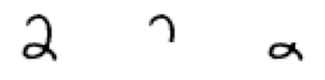

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}_{cluster_name}_{sample_index}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

## Digit 9

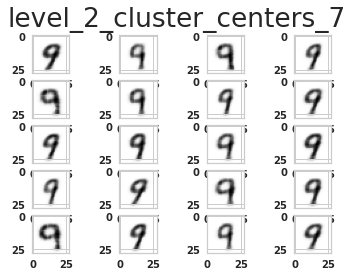

Number of image is 5933. Displaying only first 36 images 


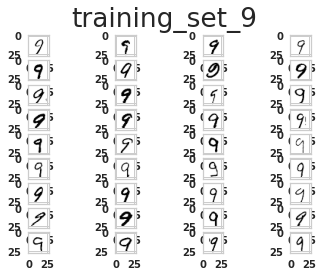

In [ ]:
digit = 9
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

In [ ]:
offset = 4
sample_index = start_index + offset
cluster_name = f"training_set_{digit}"

# if choosing from cluster, chnage the digit
# if"level_2_cluster_centers_{manual_label_to_cluster_id_map[digit]}"
# image_set_dict[f"level_2_cluster_centers_{cluster_id}"] = level2_manual_annotations_good_cluster[cluster_id]["decoded_images"]

# Choose a good symbol  the class from above
# Straight, all all features clearyly vision
digit_image = image_set_dict[cluster_name][sample_index]
digit_image = np.expand_dims(digit_image, axis=0) 


In [ ]:
#image_segments = segment( digit_image, h_extend = [], v_extend = [3,17], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)

h_extend = [ ]
v_extend = [3, 17]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])


In [ ]:
#image_segments=segment( digit_image, h_extend = [], v_extend = [17,28], digit = digit, num_clusters=num_clusters , exp_config=_exp_config,
#        cluster=cluster_name, sample_index=sample_index)
h_extend = [ ]
v_extend = [17, 28]
if digit not in image_list.keys():
    image_list[digit] = [ [digit_image,
                    h_extend,
                    v_extend,
                    digit,
                    num_clusters,
                    cluster_name,
                    sample_index]]
else:        
    image_list[digit].append( [digit_image,
                        h_extend,
                        v_extend,
                        digit,
                        num_clusters,
                        cluster_name,
                        sample_index])

<class 'list'> 2
7
Image shape (28, 28, 1)
[0, 28] [3, 17] (28, 28, 1)
0 14.0 5.6000000000000005
7
Image shape (28, 28, 1)
[0, 28] [17, 28] (28, 28, 1)
0 14.0 5.6000000000000005
Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/Concepts_from_class_9.png


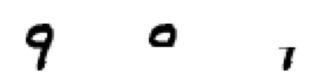

(None,)

In [ ]:
image_segments[digit] = segment_multiple_images(_exp_config, image_list[digit])
title = f"Concepts from class {digit}"
display_image_shape = list(image_segments[digit].shape)
display_image_shape[0] = display_image_shape[0] + 1
image_with_segments = np.zeros(display_image_shape)
image_with_segments[0,:,:,:] = digit_image
image_with_segments[1:,:,:,:] = image_segments[digit]
fig_width = (5/4) * image_with_segments.shape[0]
display_images(image_with_segments, _exp_config.ANALYSIS_PATH + title.replace(" ", "_" ) + ".png" , title=None, fig_size=(5, 1), axis="off", num_cols=image_with_segments.shape[0]), 

# Digit 0

Number of image is 5906. Displaying only first 36 images 


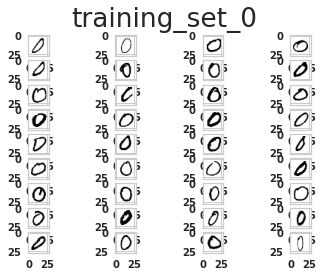

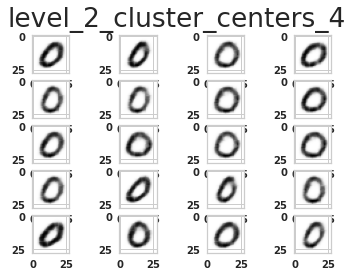

In [ ]:
digit = 0
start_index = 0
for cluster_name, image_set in image_set_dict.items():
    digit_label = get_digit_label(cluster_name)
    if digit_label != digit:
        continue
    display_images(image_set,
                   None,
                   cluster_name
                   )

# Reconstruction of segments 

In [ ]:
tf.reset_default_graph()
from copy import copy
image_segments_set_1 = copy(image_segments[2])
image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[3]])
image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[4]])
image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[5]])
#image_segments_set_1 = np.vstack([image_segments_set_1, image_segments[6]])

print(image_segments_set_1.shape)

# with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
#     model = get_model(dao = _exp_config.dao,
#                       exp_config=_exp_config,
#                       model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
#                       num_epochs=1,
#                       sess=sess,
#                       test_data_iterator=None,
#                       train_val_data_iterator=None
#                       )
#     mu, sigms, z, features_dict = encode_and_get_features(model,
#                                                           image_segments[8],
#                                                           _exp_config.BATCH_SIZE,
#                                                           _exp_config.Z_DIM
#                                                           )    

# indices_of_similar_images =[0,3,7,9]
# latent_vectors_6_reshaped_similar = latent_vectors_6_reshaped[indices_of_similar_images]
# display_images(latent_vectors_6_reshaped_similar, None, "Latent Images for digit 6", 10)
# display_images(np.squeeze(reconstructed_images_6), None, "Reconstructed image for digit 6", 10)
# for layer_num in range(4):
#   display_images(np.squeeze(features_dict[feature_names[layer_num]][:,:,:,0]),
#                 None,
#                 f"Decoder hidden layer {layer_num} Images for cluster center",
#                 10)


(8, 28, 28, 1)


In [ ]:
# def display_images(decoded_images,
#                    image_filename,
#                    title,
#                    num_images_to_display = 0,
#                    fig_size=None,
#                    axis = None,
#                    num_cols=4,
#                    ):


In [ ]:
file_name = _exp_config.ANALYSIS_PATH  + "manual_concepts_2_6.pdf"

In [ ]:
file_name

'/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/manual_concepts_2_6.pdf'

Saving the image to /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/analysis/manual_concepts_2_6.pdf


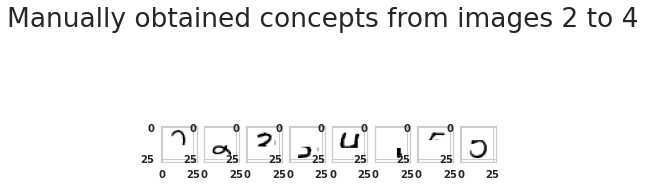

In [ ]:
display_images(image_segments_set_1, file_name, "Manually obtained concepts from images 2 to 4",num_cols=image_segments_set_1.shape[0])

In [ ]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )    

# indices_of_similar_images =[0,3,7,9]
# latent_vectors_6_reshaped_similar = latent_vectors_6_reshaped[indices_of_similar_images]
# display_images(latent_vectors_6_reshaped_similar, None, "Latent Images for digit 6", 10)
# display_images(np.squeeze(reconstructed_images_6), None, "Reconstructed image for digit 6", 10)
# for layer_num in range(4):
#   display_images(np.squeeze(features_dict[feature_names[layer_num]][:,:,:,0]),
#                 None,
#                 f"Decoder hidden layer {layer_num} Images for cluster center",
#                 10)


Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

In [ ]:
reconstructed_images.shape

(4, 28, 28, 1)

In [ ]:
print(z.shape)

(4, 16)


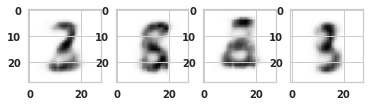

In [ ]:
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

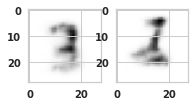

In [ ]:
digit = 2
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

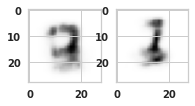

In [ ]:
digit = 2
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

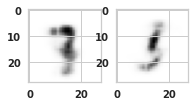

In [ ]:
digit = 3
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

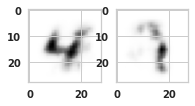

In [ ]:
digit = 4
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

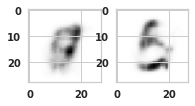

In [ ]:
digit = 5
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

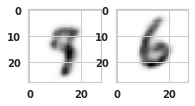

In [ ]:
digit = 6
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)

Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Image shape [28, 28, 1]
[(28, 28, 1), (14, 14, 16), (7, 7, 16), (4, 4, 16), (4, 4, 16), 16]
[16, 16, 16, 16]
Encoding
Decoding
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/ State model_checkpoint_path: "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/experiment_16_16_16_16/Exp_16_16_16_16_16_ELBOW_14/trained_models/SemiSupervisedClassifierMnist.model-46750"
all_model_checkpoin

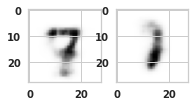

In [ ]:
digit = 7
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    mu, sigms, z, features_dict = encode_and_get_features(model,
                                                          image_segments[digit],
                                                          _exp_config.BATCH_SIZE,
                                                          _exp_config.Z_DIM
                                                          )
    
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = _exp_config.dao,
                      exp_config=_exp_config,
                      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                      num_epochs=1,
                      sess=sess,
                      test_data_iterator=None,
                      train_val_data_iterator=None
                      )
    feature_names, reconstructed_images, features_dict = decode_and_get_features(model,
                                                          z,
                                                          _exp_config.BATCH_SIZE
                                                          )  
display_images(reconstructed_images, None, None)